## NLP & Risk/Condition Classification

Predictive Modeling and Risk Analysis of Automobiles

Датасет: Kolesa.kz (2,020 объявлений)

#### 1. ЗАГРУЗКА ДАННЫХ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

df = pd.read_csv('../data/processed/kolesa_cleaned.csv')

print(f"Всего объявлений: {len(df)}")
print(f"Пропуски в description: {df['description'].isna().sum()}")
print("\nПервые строки:")
print(df[['title', 'description', 'price', 'year']].head(3))

Всего объявлений: 2020
Пропуски в description: 0

Первые строки:
                  title                                        description  \
0  ВАЗ (Lada) Lada 2121  2008 г., Б/у внедорожник, 1.7 л, бензин, КПП м...   
1     Mitsubishi Delica  1995 г., Б/у минивэн, 3 л, бензин, Правый руль...   
2               BMW 528  2012 г., Б/у седан, 2 л, бензин, КПП автомат, ...   

       price    year  
0  2000000.0  2008.0  
1  8500000.0  1995.0  
2  6500000.0  2012.0  


#### 2. РАСШИРЕННАЯ ОБРАБОТКА ТЕКСТА

In [2]:
# Русские стоп-слова (расширенный список)
RUSSIAN_STOPWORDS = {
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как',
    'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты',
    'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'ее', 'мне',
    'есть', 'они', 'тут', 'где', 'над', 'для', 'или', 'при',
    'без', 'до', 'после', 'от', 'про', 'очень', 'также',
    'ещё', 'уже', 'если', 'чтобы', 'это', 'эти', 'этот', 'эта',
    'быть', 'был', 'была', 'были', 'будет', 'буду'
}

def handle_negations(text):
    """Обработка отрицаний - склеивание 'не' с следующим словом"""
    if pd.isna(text):
        return ""
    
    text = text.lower()
    
    replacements = {
        'не бит': 'небит',
        'не крашен': 'некрашен',
        'не аварийный': 'неаварийный',
        'не утоплен': 'неутоплен',
        'не восстановлен': 'невосстановлен',
        'без дтп': 'бездтп',
        'не требует': 'нетребует'
    }
    
    for k, v in replacements.items():
        text = text.replace(k, v)
    
    return text

def clean_text(text):
    """Полная очистка текста"""
    if pd.isna(text):
        return ""
    
    # Обработка отрицаний
    text = handle_negations(text)
    
    # Убрать цифры
    text = re.sub(r'\d+', ' ', text)
    
    # Убрать пунктуацию и спецсимволы
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Убрать лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация и удаление стоп-слов
    tokens = text.split()
    tokens = [t for t in tokens if t not in RUSSIAN_STOPWORDS and len(t) > 2]
    
    return " ".join(tokens)

# Применяем очистку
df['clean_description'] = df['description'].apply(clean_text)

print("\n=== ПРИМЕР ОЧИСТКИ ===")
for i in range(3):
    print(f"\nОригинал: {df.iloc[i]['description'][:100]}...")
    print(f"Очищено:  {df.iloc[i]['clean_description'][:100]}...")


=== ПРИМЕР ОЧИСТКИ ===

Оригинал: 2008 г., Б/у внедорожник, 1.7 л, бензин, КПП механика, с пробегом 160 000 км, белый, велюр, Машина в...
Очищено:  внедорожник бензин кпп механика пробегом белый велюр машина отличном состояни...

Оригинал: 1995 г., Б/у минивэн, 3 л, бензин, Правый руль, КПП автомат, с пробегом 220 000 км, черный, металлик...
Очищено:  минивэн бензин правый руль кпп автомат пробегом черный металлик литые диски тон...

Оригинал: 2012 г., Б/у седан, 2 л, бензин, КПП автомат, с пробегом 273 000 км, черный, литые диски, тонировка,...
Очищено:  седан бензин кпп автомат пробегом черный литые диски тонировка люк спойлер обв...


#### 3. СОЗДАНИЕ МЕТОК С РАСШИРЕННЫМИ КЛЮЧЕВЫМИ СЛОВАМИ

In [3]:
# ЗНАЧИТЕЛЬНО расширенные списки ключевых слов
high_risk_words = [
    # ДТП и аварии
    "дтп", "авари", "аварийн", "битая", "битый", "бит",
    
    # Серьезные повреждения
    "перевер", "переворот", "утоп", "утопл", "затопл",
    "лонжерон", "геометр", "рама", "кузов",
    
    # Восстановление
    "восстанов", "восст", "после дтп",
    
    # Не на ходу
    "не на ходу", "неходу", "не заводится", "не едет",
    "требует серьезн", "капремонт", "капитальн",
    
    # Специфические проблемы
    "распил", "конструктор", "airbag", "подушк безопасн",
    "двс", "двигател", "коробк", "акпп", "мкпп",
    "турбин", "компрессор"
]

medium_risk_words = [
    # Ремонт
    "ремонт", "ремонте", "требует", "нужн", "необходим",
    
    # Вложения
    "влож", "вложен", "вклад", "инвест",
    
    # Покраска
    "краш", "крашен", "подкраш", "перекраш", "покраш",
    
    # Мелкие повреждения
    "царапин", "скол", "вмятин", "сколы", "царап",
    
    # Расходники
    "масл", "фильтр", "свеч", "тормоз", "колодк",
    "шин", "резин", "аккумулятор",
    
    # Ходовая
    "ходов", "подвеск", "амортизатор", "стойк",
    "рычаг", "шарнир", "сайлентблок",
    
    # Стук и шум
    "стук", "шум", "люфт", "течь", "подтек"
]

good_condition_words = [
    # Идеальное состояние
    "идеал", "отличн", "превосходн", "новая", "новый",
    
    # Без проблем
    "небит", "некрашен", "неаварийн", "бездтп",
    "без дтп", "не бит", "не краш",
    
    # Обслуживание
    "обслуж", "сервис", "то пройден", "ухожен",
    
    # Один хозяин
    "один хозя", "первый хозя", "хозяин",
    
    # Оригинал
    "оригинал", "родн", "заводск",
    
    # Не требует вложений
    "не требует влож", "нетребует", "садись езди"
]

def assign_risk_label(text):
    """Улучшенная функция присвоения меток"""
    text_lower = str(text).lower()
    
    # Сначала проверяем HIGH RISK
    for word in high_risk_words:
        if word in text_lower:
            return 2
    
    # Потом MEDIUM RISK
    for word in medium_risk_words:
        if word in text_lower:
            return 1
    
    # По умолчанию EXCELLENT
    return 0

df['risk_label'] = df['clean_description'].apply(assign_risk_label)

print("\n=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===")
print(df['risk_label'].value_counts().sort_index())
print("\nПроцентное соотношение:")
print(df['risk_label'].value_counts(normalize=True).sort_index())

# Статистика по ценам
print("\n=== СРЕДНЯЯ ЦЕНА ПО КЛАССАМ ===")
price_by_risk = df.groupby('risk_label')['price'].agg(['mean', 'median', 'count'])
price_by_risk.index = ['Excellent', 'Needs Attention', 'High Risk']
print(price_by_risk)


=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
risk_label
0    1621
1     311
2      88
Name: count, dtype: int64

Процентное соотношение:
risk_label
0    0.802475
1    0.153960
2    0.043564
Name: proportion, dtype: float64

=== СРЕДНЯЯ ЦЕНА ПО КЛАССАМ ===
                         mean     median  count
Excellent        1.212167e+07  7800000.0   1621
Needs Attention  8.403249e+06  5900000.0    311
High Risk        9.437500e+06  4600000.0     88


#### 4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ

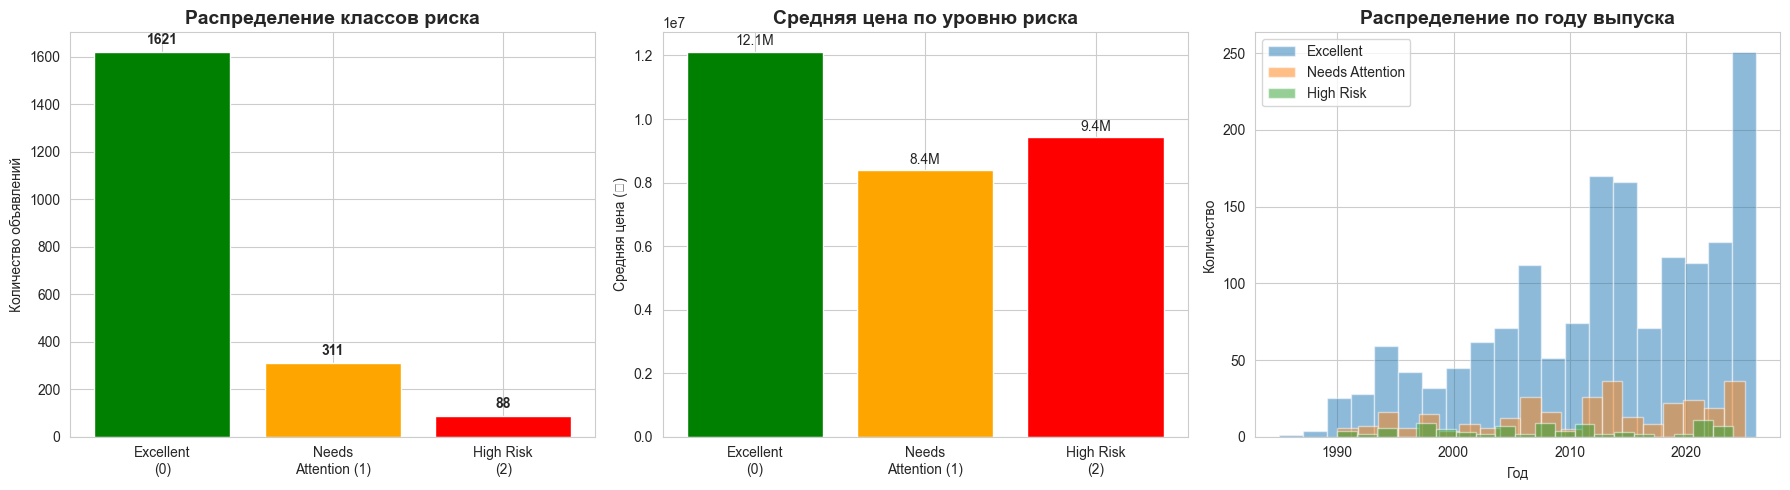

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Количество по классам
counts = df['risk_label'].value_counts().sort_index()
axes[0].bar(['Excellent\n(0)', 'Needs\nAttention (1)', 'High Risk\n(2)'], 
            counts.values, color=['green', 'orange', 'red'])
axes[0].set_title('Распределение классов риска', fontsize=14, weight='bold')
axes[0].set_ylabel('Количество объявлений')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# График 2: Средняя цена
price_means = df.groupby('risk_label')['price'].mean()
axes[1].bar(['Excellent\n(0)', 'Needs\nAttention (1)', 'High Risk\n(2)'], 
            price_means.values, color=['green', 'orange', 'red'])
axes[1].set_title('Средняя цена по уровню риска', fontsize=14, weight='bold')
axes[1].set_ylabel('Средняя цена (₸)')
for i, v in enumerate(price_means.values):
    axes[1].text(i, v + 100000, f'{v/1e6:.1f}M', ha='center', va='bottom')

# График 3: Распределение года выпуска
for label in [0, 1, 2]:
    data = df[df['risk_label'] == label]['year'].dropna()
    axes[2].hist(data, bins=20, alpha=0.5, 
                 label=['Excellent', 'Needs Attention', 'High Risk'][label])
axes[2].set_title('Распределение по году выпуска', fontsize=14, weight='bold')
axes[2].set_xlabel('Год')
axes[2].set_ylabel('Количество')
axes[2].legend()

plt.tight_layout()
plt.savefig('../results/risk_distribution_improved.png', dpi=300, bbox_inches='tight')
plt.show()

#### 5. ПРИМЕРЫ ИЗ КАЖДОГО КЛАССА

In [5]:
print("\n=== ПРИМЕРЫ ИЗ КАЖДОГО КЛАССА ===")
for label in [0, 1, 2]:
    label_name = ['Excellent', 'Needs Attention', 'High Risk'][label]
    print(f"\n{'='*60}")
    print(f"КЛАСС {label}: {label_name}")
    print('='*60)
    
    samples = df[df['risk_label'] == label].sample(min(3, len(df[df['risk_label'] == label])))
    
    for idx, row in samples.iterrows():
        print(f"\nTitle: {row['title']}")
        print(f"Price: {row['price']:,.0f} ₸")
        print(f"Year: {row['year']}")
        print(f"Description: {row['description'][:200]}...")
        print(f"Cleaned: {row['clean_description'][:150]}...")


=== ПРИМЕРЫ ИЗ КАЖДОГО КЛАССА ===

КЛАСС 0: Excellent

Title: Toyota Camry
Price: 8,000,000 ₸
Year: 2014.0
Description: 2014 г., Б/у седан, 2.5 л, бензин, КПП автомат, с пробегом 190 000 км, серый, металлик, литые диски, тонировка, ксенон......
Cleaned: седан бензин кпп автомат пробегом серый металлик литые диски тонировка ксенон...

Title: Geely Jiaji
Price: 9,800,000 ₸
Year: 2022.0
Description: 2022 г., Б/у минивэн, 1.5 л, гибрид, КПП робот, с пробегом 40 000 км, голубой, металлик...
Cleaned: минивэн гибрид кпп робот пробегом голубой металлик...

Title: Toyota Land Cruiser Prado
Price: 17,800,000 ₸
Year: 2014.0
Description: 2014 г., Б/у внедорожник, 2.7 л, бензин, КПП автомат, с пробегом 189 000 км, белый, литые диски, тонировка, спойлер, в......
Cleaned: внедорожник бензин кпп автомат пробегом белый литые диски тонировка спойлер...

КЛАСС 1: Needs Attention

Title: FAW 6390
Price: 2,000,000 ₸
Year: 2014.0
Description: 2014 г., Б/у минивэн, 1.3 л, бензин, КПП механика, с пробегом 11

#### 6. РАЗДЕЛЕНИЕ НА TRAIN/TEST

In [6]:
from sklearn.model_selection import train_test_split

X_text = df['clean_description']
y = df['risk_label']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n=== РАЗМЕРЫ ДАТАСЕТОВ ===")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print(f"\nРаспределение в train:")
print(y_train.value_counts().sort_index())
print(f"\nРаспределение в test:")
print(y_test.value_counts().sort_index())


=== РАЗМЕРЫ ДАТАСЕТОВ ===
Train: 1616
Test: 404

Распределение в train:
risk_label
0    1297
1     249
2      70
Name: count, dtype: int64

Распределение в test:
risk_label
0    324
1     62
2     18
Name: count, dtype: int64


#### 7. TF-IDF ВЕКТОРИЗАЦИЯ

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 3),  # Увеличили до триграмм
    max_features=8000,   # Больше фич
    min_df=3,            # Минимальная частота
    max_df=0.8           # Максимальная частота
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\n=== TF-IDF ===")
print(f"Размерность: {X_train_tfidf.shape}")
print(f"Количество фич: {len(tfidf.get_feature_names_out())}")

# Топ-10 самых важных слов
feature_names = tfidf.get_feature_names_out()
tfidf_scores = X_train_tfidf.sum(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]

print("\nТоп-20 слов по TF-IDF:")
for idx in top_indices:
    print(f"  {feature_names[idx]}: {tfidf_scores[idx]:.2f}")


=== TF-IDF ===
Размерность: (1616, 1311)
Количество фич: 1311

Топ-20 слов по TF-IDF:
  пробегом: 97.37
  автомат: 96.32
  кпп автомат: 96.13
  бензин кпп автомат: 93.77
  кпп автомат пробегом: 88.27
  автомат пробегом: 88.27
  седан: 80.75
  седан бензин: 78.32
  седан бензин кпп: 77.73
  металлик: 72.46
  тонировка: 66.36
  литые: 65.02
  диски: 64.88
  литые диски: 64.85
  кроссовер: 59.88
  литые диски тонировка: 59.47
  диски тонировка: 59.47
  механика: 57.52
  кпп механика: 57.01
  бензин кпп механика: 55.08


#### 8. SMOTE ДЛЯ БАЛАНСИРОВКИ

In [8]:
from imblearn.over_sampling import SMOTE

print("\n=== ПРИМЕНЕНИЕ SMOTE ===")
print("До SMOTE:")
print(y_train.value_counts().sort_index())

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("\nПосле SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())


=== ПРИМЕНЕНИЕ SMOTE ===
До SMOTE:
risk_label
0    1297
1     249
2      70
Name: count, dtype: int64

После SMOTE:
risk_label
0    1297
1    1297
2    1297
Name: count, dtype: int64


#### 9. ОБУЧЕНИЕ НЕСКОЛЬКИХ МОДЕЛЕЙ

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        C=1.0,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

results = {}

print("\n=== ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ ===")

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Модель: {name}")
    print('='*60)
    
    # Обучение
    model.fit(X_train_smote, y_train_smote)
    
    # Предсказания
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)
    
    # Метрики
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    try:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except:
        roc_auc = None
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc
    }
    
    print(f"\nF1-Score (macro): {f1_macro:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=["Excellent", "Needs Attention", "High Risk"],
        zero_division=0
    ))


=== ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ ===

Модель: Logistic Regression

F1-Score (macro): 0.8831
F1-Score (weighted): 0.9573
ROC-AUC: 0.9715

Classification Report:
                 precision    recall  f1-score   support

      Excellent       0.98      0.98      0.98       324
Needs Attention       0.87      0.89      0.88        62
      High Risk       0.87      0.72      0.79        18

       accuracy                           0.96       404
      macro avg       0.91      0.86      0.88       404
   weighted avg       0.96      0.96      0.96       404


Модель: Random Forest

F1-Score (macro): 0.8372
F1-Score (weighted): 0.9393
ROC-AUC: 0.9686

Classification Report:
                 precision    recall  f1-score   support

      Excellent       0.95      0.99      0.97       324
Needs Attention       0.92      0.79      0.85        62
      High Risk       0.91      0.56      0.69        18

       accuracy                           0.94       404
      macro avg       0.93      0.78

#### 10. CONFUSION MATRICES

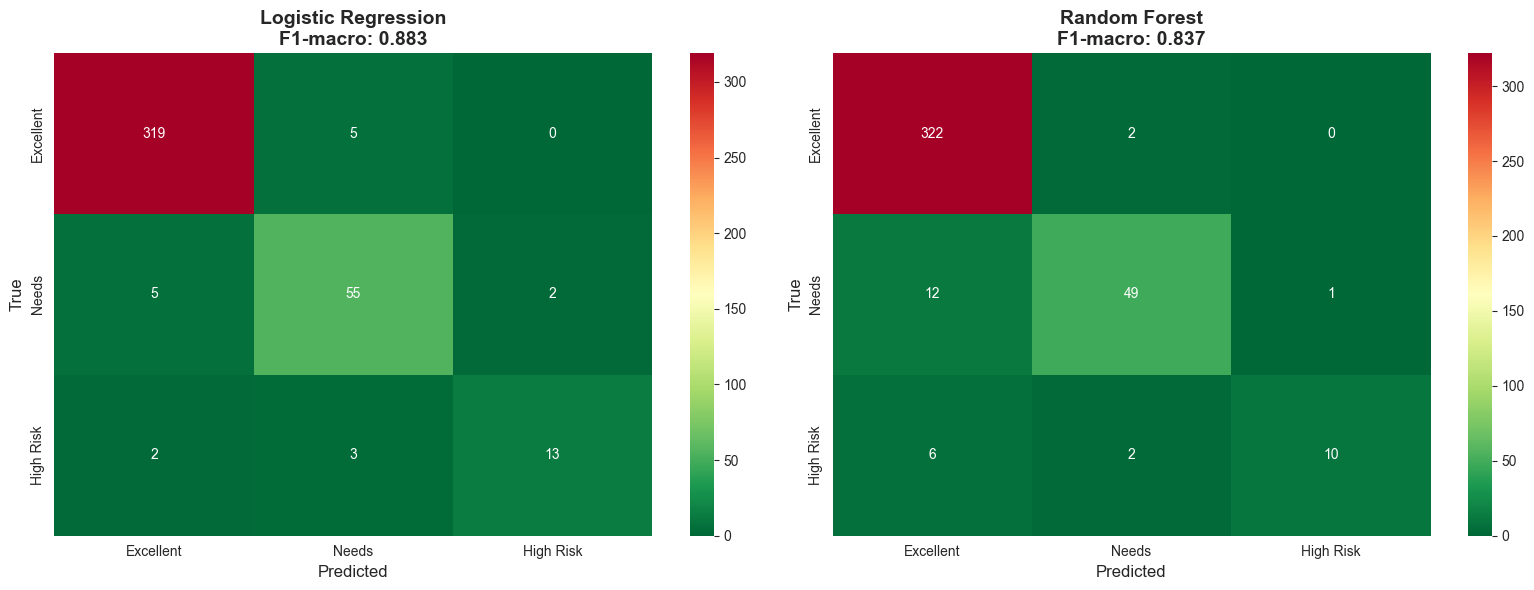

In [10]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    
    sns.heatmap(
        cm, annot=True, fmt="d", ax=axes[idx],
        xticklabels=["Excellent", "Needs", "High Risk"],
        yticklabels=["Excellent", "Needs", "High Risk"],
        cmap='RdYlGn_r'
    )
    axes[idx].set_xlabel("Predicted", fontsize=12)
    axes[idx].set_ylabel("True", fontsize=12)
    axes[idx].set_title(f'{name}\nF1-macro: {res["f1_macro"]:.3f}', 
                        fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig('../results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

#### 11. АНАЛИЗ ОШИБОК

In [11]:
print("\n=== АНАЛИЗ ОШИБОК (Logistic Regression) ===")

best_model_name = max(results, key=lambda x: results[x]['f1_macro'])
y_pred_best = results[best_model_name]['y_pred']

# Создаем датафрейм с результатами
test_results = X_test.to_frame()
test_results['true_label'] = y_test.values
test_results['pred_label'] = y_pred_best

# Находим ошибки
errors = test_results[test_results['true_label'] != test_results['pred_label']]

print(f"\nВсего ошибок: {len(errors)} из {len(y_test)} ({len(errors)/len(y_test)*100:.1f}%)")

# Типы ошибок
error_types = errors.groupby(['true_label', 'pred_label']).size()
print("\nТипы ошибок:")
for (true, pred), count in error_types.items():
    true_name = ["Excellent", "Needs Attention", "High Risk"][true]
    pred_name = ["Excellent", "Needs Attention", "High Risk"][pred]
    print(f"  {true_name} → {pred_name}: {count}")

# Примеры ошибок
print("\n=== ПРИМЕРЫ ОШИБОК ===")
for i, (idx, row) in enumerate(errors.head(10).iterrows()):
    true_name = ["Excellent", "Needs Attention", "High Risk"][row['true_label']]
    pred_name = ["Excellent", "Needs Attention", "High Risk"][row['pred_label']]
    
    print(f"\nОшибка {i+1}:")
    print(f"True: {true_name} → Predicted: {pred_name}")
    print(f"Text: {row['clean_description'][:200]}...")


=== АНАЛИЗ ОШИБОК (Logistic Regression) ===

Всего ошибок: 17 из 404 (4.2%)

Типы ошибок:
  Excellent → Needs Attention: 5
  Needs Attention → Excellent: 5
  Needs Attention → High Risk: 2
  High Risk → Excellent: 2
  High Risk → Needs Attention: 3

=== ПРИМЕРЫ ОШИБОК ===

Ошибка 1:
True: Excellent → Predicted: Needs Attention
Text: внедорожник бензин кпп механика пробегом хорошем состоянии возможен обмен...

Ошибка 2:
True: Excellent → Predicted: Needs Attention
Text: седан бензин кпп механика фаркоп налог уплачен техосмотр пройден торг обмен можно варанты...

Ошибка 3:
True: High Risk → Predicted: Needs Attention
Text: минивэн бензин правый руль кпп вариатор учет қазақ конструктор пока страховке доверен...

Ошибка 4:
True: High Risk → Predicted: Excellent
Text: фургон газ бензин кпп механика пробегом белый рама ресор усиленный обесшумка...

Ошибка 5:
True: Needs Attention → Predicted: Excellent
Text: седан бензин кпп автомат пробегом комплектация sport шумка полный бронь пленка...



#### 12. ВАЖНОСТЬ ПРИЗНАКОВ

In [12]:
print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ (Top words per class) ===")

log_reg_model = results['Logistic Regression']['model']
coefs = log_reg_model.coef_

for i, label in enumerate(["Excellent", "Needs Attention", "High Risk"]):
    top_indices = np.argsort(coefs[i])[-15:][::-1]
    
    print(f"\n{label} (Class {i}):")
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {coefs[i][idx]:.3f}")


=== ВАЖНОСТЬ ПРИЗНАКОВ (Top words per class) ===

Excellent (Class 0):
  тонировка: 1.593
  литые: 1.411
  металлик: 1.374
  диски: 1.351
  литые диски: 1.311
  аудиосистема: 1.142
  металлик литые: 1.123
  металлик литые диски: 1.003
  ксенон: 0.968
  заказ: 0.957
  литые диски тонировка: 0.943
  диски тонировка: 0.943
  ветровики: 0.901
  черный: 0.886
  люк: 0.881

Needs Attention (Class 1):
  машина: 6.117
  дневные: 3.122
  вложений: 3.118
  ходовые: 2.890
  дневные ходовые: 2.890
  вложении: 2.776
  резина: 2.433
  машины: 1.950
  машин: 1.911
  нет: 1.796
  пассат: 1.792
  машинаның: 1.741
  машину: 1.726
  ходовые огни: 1.726
  дневные ходовые огни: 1.726

High Risk (Class 2):
  кузов: 6.876
  коробка: 5.226
  двигатель: 5.211
  акпп: 4.168
  кузову: 3.918
  небит: 2.107
  двигателя: 2.073
  ремонт двигателя: 2.073
  двигатель работает: 1.830
  пробегом машина: 1.746
  ремонт: 1.743
  автомат машина: 1.677
  кпп автомат машина: 1.677
  мотор: 1.638
  матор коробка: 1.623


#### 13. СРАВНЕНИЕ МОДЕЛЕЙ (ГРАФИК)

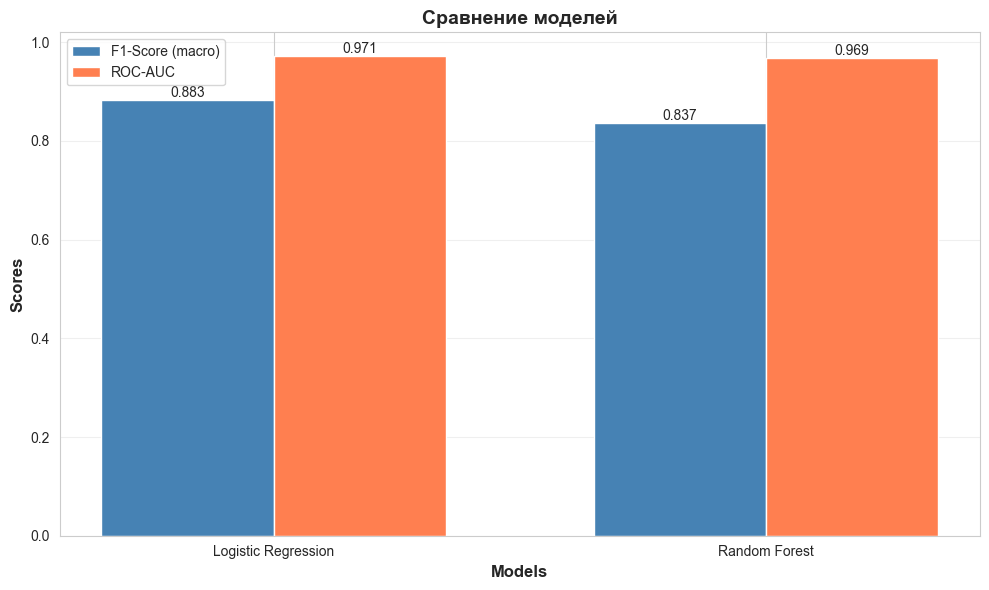

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())
f1_scores = [results[name]['f1_macro'] for name in model_names]
roc_scores = [results[name]['roc_auc'] if results[name]['roc_auc'] else 0 
              for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, f1_scores, width, label='F1-Score (macro)', color='steelblue')
bars2 = ax.bar(x + width/2, roc_scores, width, label='ROC-AUC', color='coral')

ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Scores', fontsize=12, weight='bold')
ax.set_title('Сравнение моделей', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на бары
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### 14. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

In [14]:
print("\n=== СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===")

# Сохраняем лучшую модель
import joblib

best_model = results[best_model_name]['model']
joblib.dump(best_model, '../models/best_risk_classifier.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

print(f"Лучшая модель: {best_model_name}")
print(f"F1-Score (macro): {results[best_model_name]['f1_macro']:.4f}")
print("Модели сохранены в папку 'models/'")

# Сохраняем метрики
metrics_df = pd.DataFrame({
    'Model': model_names,
    'F1_Macro': f1_scores,
    'ROC_AUC': roc_scores
})
metrics_df.to_csv('../results/model_metrics.csv', index=False)

print("\n✅ АНАЛИЗ ЗАВЕРШЕН!")
print("Результаты сохранены в папки 'results/' и 'models/'")


=== СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
Лучшая модель: Logistic Regression
F1-Score (macro): 0.8831
Модели сохранены в папку 'models/'

✅ АНАЛИЗ ЗАВЕРШЕН!
Результаты сохранены в папки 'results/' и 'models/'
